In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load traffic and weather datasets
data = pd.read_csv('traffic.csv',index_col='Date',parse_dates=True)
daily_data = data.resample('d').sum()[['Fremont Bridge Total']]
weather_data = pd.read_csv('weather_Seattle.csv', index_col='DATE',parse_dates=True)
# fix TAVG column
weather_data.TAVG.fillna(0.5*(weather_data.TMAX+weather_data.TMIN), inplace=True)

# add day_of_week, month, year and covid_pandemic columns
daily_data['day_of_week'] = daily_data.index.dayofweek
daily_data['month'] = daily_data.index.month
daily_data['year'] = daily_data.index.year
daily_data['covid_pandemic'] = (daily_data.index>'2020-03').astype(int)

# add holiday column
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012-10-03','2021-08-31')
daily_data['holiday'] = (pd.Series(1, index=holidays,name='holiday'))
daily_data['holiday'].fillna(0, inplace=True)

# add hours_of_daylight column
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    days = (date-pd.to_datetime('2000-12-21')).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days*2*np.pi/365.25)))
    return 24.*np.degrees(np.arccos(1-np.clip(m,0,2,))) / 180
daily_data['hours_daylight'] = daily_data.index.map(hours_of_daylight)

# add temperature, precipitation, average wind speed, and snowfall columns
daily_data['TAVG'] = weather_data.TAVG
daily_data['PRCP'] = weather_data.PRCP
daily_data['AWND'] = weather_data.AWND
daily_data['SNOW'] = weather_data.SNOW

daily_data.head()

,Fremont Bridge Total,day_of_week,month,year,covid_pandemic,holiday,hours_daylight,TAVG,PRCP,AWND,SNOW
Date,,,,,,,,,,,
2012-10-03,7042.0,2,10,2012,0,0.0,11.277359,56.0,0.0,16.33,0.0
2012-10-04,6950.0,3,10,2012,0,0.0,11.219142,56.5,0.0,14.54,0.0
2012-10-05,6296.0,4,10,2012,0,0.0,11.161038,59.5,0.0,12.75,0.0
2012-10-06,4012.0,5,10,2012,0,0.0,11.103056,60.5,0.0,11.41,0.0
2012-10-07,4284.0,6,10,2012,0,0.0,11.045208,60.5,0.0,2.91,0.0


## Linear regression model

In [5]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# feature matrix X/target vector y
y = daily_data['Fremont Bridge Total']
X = daily_data.drop('Fremont Bridge Total',axis=1)

# categorical processor
cat_features = ['day_of_week','month','holiday','covid_pandemic']
cat_processor = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# numerical processor
num_features = ['year','hours_daylight','TAVG','PRCP','AWND','SNOW']
num_processor = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# preprocessor
processor = ColumnTransformer(transformers=[
    ('cat_processor',cat_processor,cat_features),
    ('num_processor',num_processor,num_features)
])

# pipeline
pipe = Pipeline(steps=[
    ('preprocessor',processor),
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
    ('reg', LinearRegression())
])

# fit regression pipeline to the data
pipe.fit(X, y)

# predictions
daily_data['predictions_lin_reg'] = pipe.predict(X)

Text(0.5, 1.0, 'daily traffic')

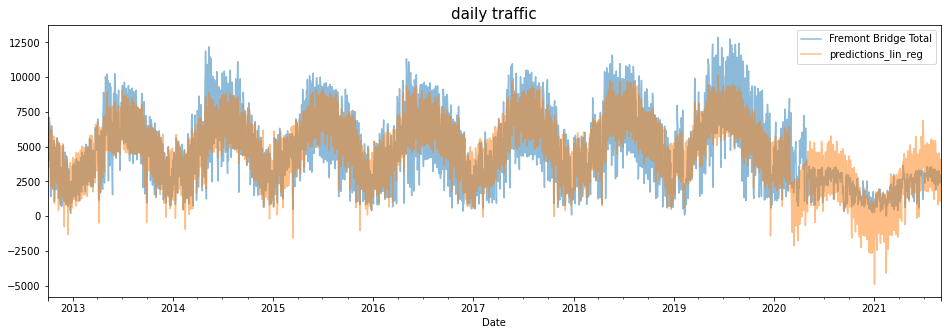

In [6]:
# plot actual and predicted values
daily_data[['Fremont Bridge Total','predictions_lin_reg']].plot(alpha=0.5, figsize=(16,5))
plt.title('daily traffic',fontsize=15)

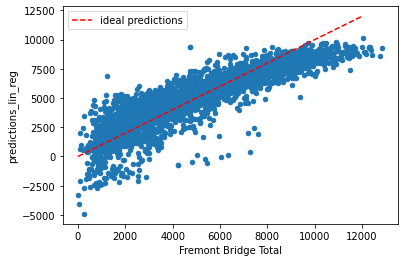

In [7]:
# plot actual against predicted values
daily_data.plot.scatter(x='Fremont Bridge Total', y ='predictions_lin_reg')
plt.plot([0,12000],[0,12000],'r--', label='ideal predictions')
plt.legend()

## Random Forest

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [11]:
# pipeline
pipe = Pipeline(steps=[
    ('preprocessor',processor),
    ('reg', RandomForestRegressor(n_jobs=-1))
])

In [12]:
parameters = {"reg__min_samples_leaf" : [1,2, 4,  8,], # default 1
              "reg__min_samples_split" : [2,4,8,16], # default 2
              "reg__n_estimators" : [50,100,200], # default 100
              "reg__max_depth" : [2,5,10]} # default None (unlimited)

grid = GridSearchCV(pipe, parameters,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=True)
grid.fit(X,y)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  3.8min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_processor',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month',
                                                                          'holiday',
                                                                          'covid_pandemic']),
                                                                        ('num_processor',
                                                                         Pipeline(steps=[('scaler',
                                                           

In [14]:
# best model from the grid search
best_clf = grid.best_estimator_

# fit regression pipeline to the data
best_clf.fit(X, y)

# predictions
daily_data['predictions_ran_for'] = best_clf.predict(X)

Text(0.5, 1.0, 'daily traffic')

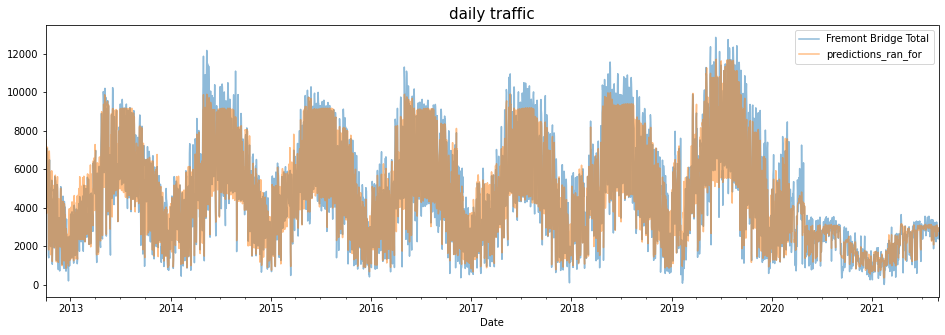

In [15]:
# plot actual and predicted values
daily_data[['Fremont Bridge Total','predictions_ran_for']].plot(alpha=0.5, figsize=(16,5))
plt.title('daily traffic',fontsize=15)

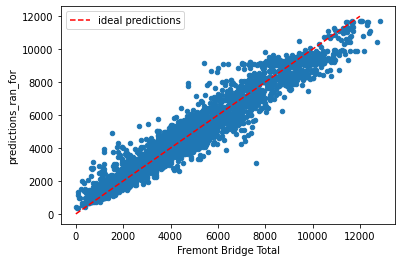

In [17]:
# plot actual against predicted values
daily_data.plot.scatter(x='Fremont Bridge Total', y ='predictions_ran_for')
plt.plot([0,12000],[0,12000],'r--', label='ideal predictions')
plt.legend()